In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm

tqdm.pandas()

In [2]:
from joblib import dump, load

encoder = OneHotEncoder(sparse=False)
products = pd.read_feather('./Data/products.ftr')

temp = products[['product_id', 'group']].set_index('product_id')
temp = temp.join(temp, how='outer', lsuffix='1', rsuffix='2').reset_index(drop=True)
encoder = encoder.fit(temp)
dump(encoder, 'encoder.joblib') 

['encoder.joblib']

In [3]:
dataset = pd.read_feather('./Data/dataset.ftr')
dataset.columns

Index(['title1', 'group1', 'salesrank1', 'co_purchased_num1', 'categories1',
       'reviews_num1', 'avg_rate1', 'first_rating_time1', 'last_rating_time1',
       'highest_rate1', 'lowest_rate1', 'title2', 'group2', 'salesrank2',
       'co_purchased_num2', 'categories2', 'reviews_num2', 'avg_rate2',
       'first_rating_time2', 'last_rating_time2', 'highest_rate2',
       'lowest_rate2', 'label'],
      dtype='object')

In [4]:
dataset['sales_diff'] = dataset['salesrank1'] - dataset['salesrank2']
dataset['co_purchased_diff'] = dataset['co_purchased_num1'] - dataset['co_purchased_num2']

dataset['reviews_num_diff'] = dataset['reviews_num1'] - dataset['reviews_num2']
dataset['avg_rating_diff'] = dataset['avg_rate1'] - dataset['avg_rate2']
dataset['first_time_diff'] = dataset['first_rating_time1'] - dataset['first_rating_time2']
dataset['last_time_diff'] = dataset['last_rating_time1'] - dataset['last_rating_time2']
dataset['highest_rating_diff'] = dataset['highest_rate1'] - dataset['highest_rate2']
dataset['lowest_rating_diff'] = dataset['lowest_rate1'] - dataset['lowest_rate2']

In [5]:
def calc_categ_simi(set1, set2):
    join = set1 | set2
    return len(set1 & set2) / len(join) if len(join) != 0 else 0
dataset['categ_simi'] = dataset.progress_apply(lambda x: 
    calc_categ_simi(set(x['categories1']), set(x['categories2'])), axis=1)

dataset.drop(columns=['categories1', 'categories2'], inplace=True)
dataset.drop(columns=['title1', 'title2'], inplace=True)

  0%|          | 0/2013128 [00:00<?, ?it/s]

In [6]:
dataset.shape

(2013128, 28)

In [7]:
from joblib import dump, load
encoder = load('encoder.joblib') 

X = pd.concat([pd.DataFrame(MinMaxScaler().fit_transform(dataset.drop(columns=['group1', 'group2', 'label']))), 
               pd.DataFrame(encoder.transform(dataset[['group1', 'group2']]))], axis=1)
cols = list(dataset.drop(columns=['group1', 'group2', 'label']).columns)
cols.extend(list(encoder.get_feature_names_out(['group1', 'group2'])))
X.columns = cols

y = dataset['label']

In [8]:
X.columns

Index(['salesrank1', 'co_purchased_num1', 'reviews_num1', 'avg_rate1',
       'first_rating_time1', 'last_rating_time1', 'highest_rate1',
       'lowest_rate1', 'salesrank2', 'co_purchased_num2', 'reviews_num2',
       'avg_rate2', 'first_rating_time2', 'last_rating_time2', 'highest_rate2',
       'lowest_rate2', 'sales_diff', 'co_purchased_diff', 'reviews_num_diff',
       'avg_rating_diff', 'first_time_diff', 'last_time_diff',
       'highest_rating_diff', 'lowest_rating_diff', 'categ_simi',
       'group1_Baby Product', 'group1_Book', 'group1_CE', 'group1_DVD',
       'group1_Music', 'group1_Software', 'group1_Sports', 'group1_Toy',
       'group1_Video', 'group1_Video Games', 'group2_Baby Product',
       'group2_Book', 'group2_CE', 'group2_DVD', 'group2_Music',
       'group2_Software', 'group2_Sports', 'group2_Toy', 'group2_Video',
       'group2_Video Games'],
      dtype='object')

In [9]:
kfold = KFold(n_splits=5, shuffle=True, random_state=12345)

In [10]:
reg = LogisticRegression(random_state=12345, solver='sag')

rfecv = RFECV(
    estimator=reg,
    cv=kfold,
    scoring="accuracy",
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X, y)

C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


RFECV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
      estimator=LogisticRegression(random_state=12345, solver='sag'),
      min_features_to_select=5, n_jobs=-1, scoring='accuracy')

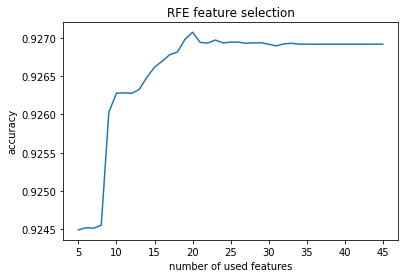

In [11]:
plt.plot(range(5, len(X.columns)+1), rfecv.cv_results_['mean_test_score'])
plt.title('RFE feature selection')
plt.xlabel('number of used features')
plt.ylabel('accuracy')
plt.show()

In [12]:
rfecv.support_

array([ True,  True,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
        True,  True, False, False,  True,  True,  True, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False])

In [13]:
X[X.columns[rfecv.support_]]

,salesrank1,co_purchased_num1,reviews_num1,salesrank2,co_purchased_num2,reviews_num2,avg_rate2,first_rating_time2,last_rating_time2,sales_diff,reviews_num_diff,avg_rating_diff,highest_rating_diff,lowest_rating_diff,categ_simi,group1_Book,group1_Music,group1_Software,group2_Toy,group2_Video
0,0.126857,1.0,0.000200,0.027892,1.0,0.000400,0.875,0.838308,0.887106,0.565166,0.595846,0.5625,0.5,0.625,0.666667,1.0,0.0,0.0,0.0,0.0
1,0.126857,1.0,0.000200,0.027505,1.0,0.002603,0.875,0.809732,0.985888,0.565366,0.594533,0.5625,0.5,0.625,0.538462,1.0,0.0,0.0,0.0,0.0
2,0.126857,1.0,0.000200,0.019373,1.0,0.000601,0.875,0.841403,0.725235,0.569582,0.595727,0.5625,0.5,0.750,0.777778,1.0,0.0,0.0,0.0,0.0
3,0.126857,1.0,0.000200,0.212221,1.0,0.000400,0.500,0.863629,0.776148,0.469619,0.595846,0.7500,0.5,1.000,0.666667,1.0,0.0,0.0,0.0,0.0
4,0.053930,1.0,0.002203,0.092943,1.0,0.001802,0.750,0.900222,0.965412,0.496158,0.596204,0.5625,0.5,0.375,0.545455,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013123,0.001203,1.0,0.060873,0.028058,1.0,0.000000,1.000,0.958406,0.851688,0.504277,0.632251,0.4375,0.5,0.000,0.024691,0.0,0.0,0.0,0.0,0.0
2013124,0.001203,1.0,0.060873,0.038232,1.0,0.001001,0.750,0.825290,0.666851,0.499003,0.631654,0.5625,0.5,0.250,0.012658,0.0,0.0,0.0,0.0,0.0
2013125,0.001203,1.0,0.060873,0.230050,0.4,0.000000,1.000,0.986903,0.951024,0.399574,0.632251,0.4375,0.5,0.000,0.012658,0.0,0.0,0.0,0.0,0.0
2013126,0.001203,1.0,0.060873,0.052538,1.0,0.021025,1.000,0.756549,0.994189,0.491588,0.619718,0.4375,0.5,0.250,0.023256,0.0,0.0,0.0,0.0,0.0


In [14]:
X = X[X.columns[rfecv.support_]]

In [15]:
X.to_feather('./Data/X.ftr')
pd.DataFrame(dataset['label']).to_feather('./Data/y.ftr')

In [16]:
base_model = LogisticRegression(random_state=12345, n_jobs=-1)
kfold_gridsearchcv = KFold(n_splits=3, shuffle=True, random_state=12345)

param_grid = {'tol': [1e-6, 1e-4, 1e-2],
              'C': [0.01, 0.1, 1],
              'max_iter': [1000, 10000, 100000],
              'solver': ['sag', 'saga']}

RSCV = GridSearchCV(base_model, param_grid, scoring='accuracy', 
                    n_jobs=-1, cv=kfold_gridsearchcv, verbose=10)
RSCV.fit(X, y)
RSCV.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'C': 0.1, 'max_iter': 1000, 'solver': 'sag', 'tol': 1e-06}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

logreg = LogisticRegression(random_state=12345, n_jobs=-1, C=0.1,
                            solver='sag', max_iter=1000, tol=1e-06).fit(X_train, y_train)
logreg.score(X_test, y_test)

0.9281318146369087

In [18]:
model = LogisticRegression(random_state=12345, n_jobs=-1, C=0.1,
                            solver='sag', max_iter=1000, tol=1e-06)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

print(f'Result: mean = {cv_scores.mean()} with std = {cv_scores.std()}')

Result: mean = 0.9270682240091007 with std = 0.00031719938097937413


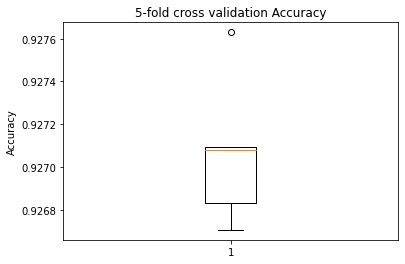

In [19]:
plt.boxplot(cv_scores)
plt.ylabel('Accuracy')
plt.title('5-fold cross validation Accuracy')
plt.show()

In [20]:
cv_scores

array([0.92763011, 0.92707873, 0.92683284, 0.92709345, 0.92670599])

In [21]:
from joblib import dump, load
logreg = LogisticRegression(random_state=12345, n_jobs=-1, C=0.1,
                            solver='sag', max_iter=1000, tol=1e-06).fit(X, y)
dump(logreg, 'logreg.joblib') 

['logreg.joblib']

In [22]:
logreg.coef_

array([[ -1.3623693 ,   3.67828072,   1.37244854, -11.83102994,
          3.59763324,   2.91956781,   0.82770438,  -1.44733947,
          0.82812586,   5.47337824,  -0.92221608,  -1.16119417,
          1.24265184,   0.85586039,  16.5706092 ,  -1.46278336,
         -1.43705309,   0.09353643,   0.23652191,  -0.86215144]])

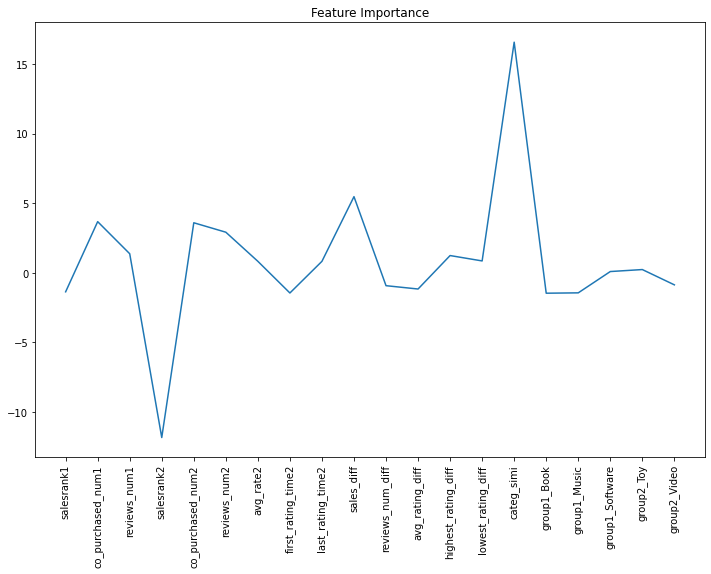

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(X.columns, logreg.coef_[0])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()